# Predicting Changes in the Zillow Home Value Index by Zip Code

In this notebook, I complete EDA of various Zillow data available by zip code, then build predictive models to estimate the probability that the Zillow Home Value Index (ZHVI) will change by *x* percent over the next *n* months for a given zip code. The resulting models may be a helpful tool for people considering selling their home in making decisions about when to sell over the next twelve months: sell now, wait three months, wait six months, wait a year, etc.

### Import Libraries

In [1158]:
import pandas as pd
import matplotlib as plt
from functools import reduce
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Load Data

In [836]:
zhvi_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/Zip_Zhvi_SingleFamilyResidence.csv',encoding = "ISO-8859-1")

In [837]:
zhvi_rental_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/Zip_Zri_SingleFamilyResidenceRental.csv',encoding = "ISO-8859-1")

In [841]:
buyer_seller_index = pd.read_csv('/Users/philglazer/Desktop/zillow_data/BuyerSellerIndexCrossTime_Zip.csv',encoding = "ISO-8859-1")

In [842]:
# code to clean up date columns in the buyer_seller_index table; needed to be able to join with other tables on date
# ex: turns '2018-6' into '2018-06', '2017-2' into '2017-02', etc.

for c in buyer_seller_index.columns:
    if '-' in c:
        first_digit = c.split('-')[0]
        second_digit = c.split('-')[1]
        if int(second_digit) < 10:
            temp = '0' + str(second_digit)
            buyer_seller_index.rename(columns={c:first_digit+'-'+temp},inplace=True)
        #print(c.split('-')[1])
        

In [843]:
foreclosures_resales = pd.read_csv('/Users/philglazer/Desktop/zillow_data/SalesPrevForeclosed_Share_Zip.csv',encoding = "ISO-8859-1")

In [844]:
sale_price_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/Sale_Prices_Zip.csv')

In [845]:
sale_counts_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/Sale_Counts_Zip.csv')

In [846]:
median_listing_price_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/Zip_MedianListingPrice_AllHomes.csv',encoding = "ISO-8859-1")

In [847]:
median_listing_price_persqft_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/Zip_MedianListingPricePerSqft_AllHomes.csv',encoding = "ISO-8859-1")

In [848]:
percent_listings_price_reductions_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/Zip_PctOfListingsWithPriceReductions_AllHomes.csv',encoding = "ISO-8859-1")

In [849]:
median_percent_price_reductions_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/Zip_MedianPctOfPriceReduction_AllHomes.csv',encoding = "ISO-8859-1")

In [850]:
monthly_listings_allhomes_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/MonthlyListings_NSA_AllHomes_Zip.csv',encoding = "ISO-8859-1")

In [851]:
new_monthly_listings_nsa_allhomes_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/NewMonthlyListings_NSA_AllHomes_Zip.csv',encoding = "ISO-8859-1")

In [852]:
median_daily_listings_nsa_allhomes_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/MedianDailyListings_NSA_AllHomes_Zip.csv',encoding = "ISO-8859-1")

In [853]:
price_to_rent_ratio_data = pd.read_csv('/Users/philglazer/Desktop/zillow_data/Zip_PriceToRentRatio_AllHomes.csv',encoding = "ISO-8859-1")

#### List of data available

In [854]:
# used later to iterate over the data sets available

data_sets = [zhvi_data, zhvi_rental_data, foreclosures_resales, sale_price_data, sale_counts_data, median_listing_price_data, median_listing_price_persqft_data,
            percent_listings_price_reductions_data, median_percent_price_reductions_data, monthly_listings_allhomes_data,
            new_monthly_listings_nsa_allhomes_data, median_daily_listings_nsa_allhomes_data, price_to_rent_ratio_data]

In [855]:
# removed, mostly empty:'new_monthly_listings_nsa':new_monthly_listings_nsa_allhomes_data, 
# removed, mostly empty:'median_listing_price_persqft':median_listing_price_persqft_data,
# removed, mostly empty:'sale_price':sale_price_data, 
# removed, mostly empty:'sale_counts':sale_counts_data,



data_sets_dict = {
    'zhvi':zhvi_data,
    'zhvi_rental':zhvi_rental_data,
    'buyer_seller_index':buyer_seller_index,
    'foreclose_resales':foreclosures_resales,
    'median_listing_price':median_listing_price_data, 
    'percent_listing_price_reductions':percent_listings_price_reductions_data, 
    'median_percent_price_reductions':median_percent_price_reductions_data, 
    'monthly_listings_allhomes':monthly_listings_allhomes_data,
    'median_daily_listings':median_daily_listings_nsa_allhomes_data, 
    'price_to_rent_ratio':price_to_rent_ratio_data
}

In [1130]:
zhvi_data.head(50)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04
0,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,337200.0,338200.0,339000.0,...,1041900,1044100,1047700,1049600,1048500,1048500,1052700,1057800,1067100,1076100
1,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,210400.0,212200.0,212200.0,...,336800,338100,338500,337200,336200,336100,335300,334000,333400,333200
2,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,502900.0,504900.0,506300.0,...,1320100,1320200,1319100,1318200,1319600,1322700,1328100,1334600,1340900,1342900
3,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,95400.0,95600.0,95800.0,...,177400,178100,178700,179600,180300,180900,181900,183200,182900,181500
4,93144,79936,El Paso,TX,El Paso,El Paso County,5,77300.0,77300.0,77300.0,...,123700,124600,125700,126400,126800,127500,128100,128600,128800,128800
5,91733,77084,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,6,95000.0,95200.0,95400.0,...,167500,168800,169700,170900,172400,173800,175500,177400,177500,175900
6,61807,10467,New York,NY,New York-Newark-Jersey City,Bronx County,7,151900.0,151800.0,151800.0,...,429300,433000,434000,434800,438000,442700,446400,450400,455000,458300
7,62037,11226,New York,NY,New York-Newark-Jersey City,Kings County,8,161800.0,162200.0,162500.0,...,1061600,1093500,1115700,1126900,1119900,1093800,1058200,1032400,1035700,1056900
8,84640,60640,Chicago,IL,Chicago-Naperville-Elgin,Cook County,9,218500.0,218500.0,218500.0,...,760700,756900,755900,748900,745600,749500,753500,756800,776100,799400
9,97564,94109,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,10,767700.0,772800.0,778000.0,...,3960500,3973400,3986000,4005300,4001400,4010700,4013400,3970000,3942000,3951300


In [1132]:
modeled_zipcodes = [37042, 77479, 87114, 6010, 33908, 97229, 29732, 28314, 40475, 19111]

In [1138]:
# save data down to a .csv for each zip code for visualization

for m in modeled_zipcodes:
    data = zhvi_data[zhvi_data['RegionName']==m].transpose()
    data[-76:].to_csv("/Users/philglazer/Desktop/zhvi_values_" + str(m) + ".csv")

### Helper Functions

In [857]:
# function that gets the row corresponding to a specific zip code from a given table
# the columns/rows need to be flipped, but the column names are dropped before the table is transposed
# resulting output is a dataframe with columns for date and value for a given zipcode and given data table


col_names = ['RegionID','RegionName','StateName','SizeRank','RegionType',
            'City','County','State','Metro','CountyName']

def prepare_df_for_zip(zip_code, data_set):
    data = data_set[data_set['RegionName']==zip_code]
    for c in col_names:
        if c in data.columns:
            data.drop([c],axis=1,inplace=True)
    data = data.transpose()
    data['Date'] = data.index
    return data[data['Date']>='2010-01'] #.add_prefix('hello')
    

In [858]:
prepare_df_for_zip(79936, zhvi_data).head()

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,4,Date
2010-01,117300.0,2010-01
2010-02,117300.0,2010-02
2010-03,116900.0,2010-03
2010-04,116100.0,2010-04
2010-05,115700.0,2010-05


In [985]:
# function that iterates over the data sets available and applies prepare_df_for_zip to each and stores the results of each call
# after gathering all data for a given zipcode, the function joins the data on date to return a dataframe

def join_data_available(zip_code, data_sets):
    master_df = pd.DataFrame()
    df_list = []
    for k in data_sets_dict.keys():
        data = prepare_df_for_zip(zip_code, data_sets_dict[k])#.add_prefix(k)
        for i in range(1750):
                data.rename(columns={i:k}, inplace=True)
        df_list.append(data)        
        
    df_final = reduce(lambda left,right: pd.merge(left,right,on='Date'), df_list)
    return df_final
    
    #df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['DATE'],how='outer'), data_frames)


In [1150]:
join_data_available(37042,data_sets_dict)[[
     'zhvi',
     'buyer_seller_index',
     'median_listing_price',
     'percent_listing_price_reductions',
     'median_percent_price_reductions',
     'monthly_listings_allhomes',
     'median_daily_listings',
     'price_to_rent_ratio']].corr()

,zhvi,median_listing_price,percent_listing_price_reductions,median_percent_price_reductions,monthly_listings_allhomes,median_daily_listings,price_to_rent_ratio
zhvi,1.000000,0.948334,-0.693878,-0.429393,-0.820992,-0.829060,0.939270
median_listing_price,0.948334,1.000000,-0.690667,-0.440182,-0.804277,-0.805994,0.889667
percent_listing_price_reductions,-0.693878,-0.690667,1.000000,0.377322,0.861920,0.856186,-0.766501
median_percent_price_reductions,-0.429393,-0.440182,0.377322,1.000000,0.471708,0.497123,-0.534803
monthly_listings_allhomes,-0.820992,-0.804277,0.861920,0.471708,1.000000,0.987454,-0.860882
median_daily_listings,-0.829060,-0.805994,0.856186,0.497123,0.987454,1.000000,-0.876693
price_to_rent_ratio,0.939270,0.889667,-0.766501,-0.534803,-0.860882,-0.876693,1.000000


In [1153]:
modeled_zipcodes = [37042, 77479, 87114, 6010, 33908, 97229, 29732, 28314, 40475, 19111]

In [1185]:
def make_joint_df_list_of_zips(list_of_zips, data_sets):
    list_of_dfs = []
    for l in list_of_zips:
        #list_of_dfs.append(join_data_available(l, data_sets))
        
        data = join_data_available(l, data_sets_dict).set_index('Date')

        # converts object type to float to take as a model input
        data["buyer_seller_index"] = data["buyer_seller_index"].astype(float)

        scaler = StandardScaler()
        data[['median_listing_price',
         'percent_listing_price_reductions',
         'median_percent_price_reductions',
         'monthly_listings_allhomes',
         'median_daily_listings',
         'price_to_rent_ratio']] = scaler.fit_transform(data[['median_listing_price',
         'percent_listing_price_reductions',
         'median_percent_price_reductions',
         'monthly_listings_allhomes',
         'median_daily_listings',
         'price_to_rent_ratio']])

        data['zhvi_+3mo'] = data['zhvi'].shift(-3)
        data['zhvi_+6mo'] = data['zhvi'].shift(-6)
        data['zhvi_+9mo'] = data['zhvi'].shift(-9)
        data['zhvi_+12mo'] = data['zhvi'].shift(-12)

        data['pct_change_3mo'] = (data['zhvi_+3mo'] - data['zhvi'])/data['zhvi']
        data['pct_change_6mo'] = (data['zhvi_+6mo'] - data['zhvi'])/data['zhvi']
        data['pct_change_9mo'] = (data['zhvi_+9mo'] - data['zhvi'])/data['zhvi']
        data['pct_change_12mo'] = (data['zhvi_+12mo'] - data['zhvi'])/data['zhvi']

        data['positive_3mo_change'] = data['pct_change_3mo'].apply(lambda x: 1 if x>0 else 0)
        data['positive_6mo_change'] = data['pct_change_6mo'].apply(lambda x: 1 if x>0 else 0)
        data['positive_9mo_change'] = data['pct_change_9mo'].apply(lambda x: 1 if x>0 else 0)
        data['positive_12mo_change'] = data['pct_change_12mo'].apply(lambda x: 1 if x>0 else 0)

        data['two_percent_plus_12mo'] = data['pct_change_12mo'].apply(lambda x: 1 if x>0.02 else 0)
        data['five_percent_plus_12mo'] = data['pct_change_12mo'].apply(lambda x: 1 if x>0.05 else 0)
        data['ten_percent_plus_12mo'] = data['pct_change_12mo'].apply(lambda x: 1 if x>0.1 else 0)

        # some NaN values after this date
        data = data[data.index<'2018-05']

        # make this an input variable
        # testing removal of features:'zhvi','zhvi_rental',
        features = data[[
         'buyer_seller_index',
         'median_listing_price',
         'percent_listing_price_reductions',
         'median_percent_price_reductions',
         'monthly_listings_allhomes',
         'median_daily_listings',
         'price_to_rent_ratio',
         'five_percent_plus_12mo']]
        
        list_of_dfs.append(features)
        
    return pd.concat(list_of_dfs)

In [1281]:
modeled_zipcodes = [37042, 77479, 87114, 6010, 33908, 97229, 29732, 28314, 40475, 19111]
#modeled_zipcodes = [87114]
tsne_data = make_joint_df_list_of_zips(modeled_zipcodes, data_sets_dict)

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarni

In [1282]:
tsne_data.head()

,buyer_seller_index,median_listing_price,percent_listing_price_reductions,median_percent_price_reductions,monthly_listings_allhomes,median_daily_listings,price_to_rent_ratio,five_percent_plus_12mo
Date,,,,,,,,
2013-01,0.49,-0.861583,0.759991,3.032607,0.929769,0.818580,-0.725977,0
2013-02,0.59,-0.923185,0.891470,0.850402,1.190147,1.273346,-0.803063,0
2013-03,0.39,-0.861583,1.875247,0.591711,1.105023,1.337549,-0.841606,0
2013-04,0.20,-0.858253,0.614679,1.030403,1.430495,1.391051,-0.918691,0
2013-05,0.10,-0.861583,1.098043,0.883779,1.685866,1.498055,-1.034320,0


In [1283]:
tsne = TSNE(n_components=2)
target_value = tsne_data['five_percent_plus_12mo']
tsne_results = tsne.fit_transform(tsne_data[['buyer_seller_index',
         'median_listing_price',
         'percent_listing_price_reductions',
         'median_percent_price_reductions',
         'monthly_listings_allhomes',
         'median_daily_listings',
         'price_to_rent_ratio']])


In [1284]:
tsne_Df = pd.DataFrame(data=tsne_results,columns=['principal component 1','principal component 2'])

In [1285]:
tsne_Df.reset_index(drop=True, inplace=True)
target_value.reset_index(drop=True, inplace=True)

tsne_finalDf = pd.concat([tsne_Df, target_value], axis=1)

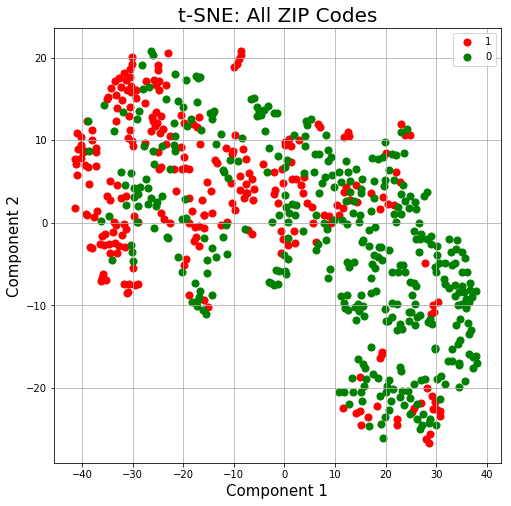

In [1288]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('t-SNE: All ZIP Codes', fontsize = 20)
targets = [1,0]
colors = ['r', 'g','b']
for target, color in zip(targets,colors):
    indicesToKeep = target_value == target
    ax.scatter(tsne_finalDf.loc[indicesToKeep, 'principal component 1']
               , tsne_finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

plt.show()

In [1287]:
def join_data_available_list_of_zips(list_of_zips, data_sets):
    master_dict = {}
    for l in list_of_zips:
        master_dict[l] = join_data_available(l, data_sets)
        
    return master_dict

In [1252]:
inter = join_data_available_list_of_zips(modeled_zipcodes, data_sets_dict)

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [1296]:
good_zips = [77449, 37013, 37042, 77479]

good_zips2 = [60629, 78704, 75287, 30024, 78745, 28027,
              48197, 66062, 95630, 90044, 90805]

good_zips3 = [92683, 37075, 87114, 6010, 78240, 87111, 76063, 33908, 97229, 91709, 92677]

# gets the data for zip codes in a list of zip_codes; this is needed to feed into the web app to power the models
data_output = join_data_available_list_of_zips(modeled_zipcodes, data_sets_dict)

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [1297]:
pickle_out = open("modeled_zipcodes_data.pickle","wb")
pickle.dump(data_output, pickle_out)
pickle_out.close()

In [1039]:
join_data_available(60629, data_sets_dict)

,zhvi,Date,zhvi_rental,buyer_seller_index,foreclose_resales,median_listing_price,percent_listing_price_reductions,median_percent_price_reductions,monthly_listings_allhomes,median_daily_listings,price_to_rent_ratio
0,113200.0,2013-01,1271.0,5.39,0.1867,99900.0,11.000000,7.240596,241.0,181.0,7.51
1,113400.0,2013-02,1274.0,2.55,0.2857,102500.0,11.805556,5.313402,221.0,174.0,7.53
2,113900.0,2013-03,1276.0,0.98,0.1724,99000.0,8.813559,8.060897,224.0,174.0,7.65
3,114700.0,2013-04,1284.0,0.69,0.3284,99900.0,7.692308,6.253909,242.0,194.0,7.77
4,116000.0,2013-05,1288.0,1.37,0.1846,101250.0,9.150327,8.386029,252.0,184.0,7.86
5,118000.0,2013-06,1292.0,2.45,0.3542,115000.0,11.575563,6.643240,247.0,186.0,7.95
6,119500.0,2013-07,1294.0,3.24,0.2800,115000.0,10.248447,5.221215,260.0,199.0,8.04
7,119700.0,2013-08,1299.0,3.73,0.2262,116500.0,14.121037,6.499430,268.0,201.0,8.05
8,119600.0,2013-09,1308.0,4.22,0.2090,117950.0,12.380952,6.071819,246.0,190.0,8.01
9,119700.0,2013-10,1324.0,5,0.2841,119000.0,15.362319,7.722008,289.0,218.0,7.96


In [1291]:
# code that takes in a zip_code and loads all available data, then performs train/test split and model fitting with a 
# random forest classifier

def run_full_model(zip_code, target_col):
    data = join_data_available(zip_code, data_sets_dict).set_index('Date')
    
    # converts object type to float to take as a model input
    data["buyer_seller_index"] = data["buyer_seller_index"].astype(float)
    
    scaler = StandardScaler()
    data[['median_listing_price',
     'percent_listing_price_reductions',
     'median_percent_price_reductions',
     'monthly_listings_allhomes',
     'median_daily_listings',
     'price_to_rent_ratio']] = scaler.fit_transform(data[['median_listing_price',
     'percent_listing_price_reductions',
     'median_percent_price_reductions',
     'monthly_listings_allhomes',
     'median_daily_listings',
     'price_to_rent_ratio']])
    
    data['zhvi_+3mo'] = data['zhvi'].shift(-3)
    data['zhvi_+6mo'] = data['zhvi'].shift(-6)
    data['zhvi_+9mo'] = data['zhvi'].shift(-9)
    data['zhvi_+12mo'] = data['zhvi'].shift(-12)

    data['pct_change_3mo'] = (data['zhvi_+3mo'] - data['zhvi'])/data['zhvi']
    data['pct_change_6mo'] = (data['zhvi_+6mo'] - data['zhvi'])/data['zhvi']
    data['pct_change_9mo'] = (data['zhvi_+9mo'] - data['zhvi'])/data['zhvi']
    data['pct_change_12mo'] = (data['zhvi_+12mo'] - data['zhvi'])/data['zhvi']

    data['positive_3mo_change'] = data['pct_change_3mo'].apply(lambda x: 1 if x>0 else 0)
    data['positive_6mo_change'] = data['pct_change_6mo'].apply(lambda x: 1 if x>0 else 0)
    data['positive_9mo_change'] = data['pct_change_9mo'].apply(lambda x: 1 if x>0 else 0)
    data['positive_12mo_change'] = data['pct_change_12mo'].apply(lambda x: 1 if x>0 else 0)
    
    data['two_percent_plus_12mo'] = data['pct_change_12mo'].apply(lambda x: 1 if x>0.02 else 0)
    data['five_percent_plus_12mo'] = data['pct_change_12mo'].apply(lambda x: 1 if x>0.05 else 0)
    data['ten_percent_plus_12mo'] = data['pct_change_12mo'].apply(lambda x: 1 if x>0.1 else 0)
    
    # some NaN values after this date
    data = data[data.index<'2018-05']
    
    # make this an input variable
    # testing removal of features:'zhvi','zhvi_rental',
    features = data[[
     'buyer_seller_index',
     'median_listing_price',
     'percent_listing_price_reductions',
     'median_percent_price_reductions',
     'monthly_listings_allhomes',
     'median_daily_listings',
     'price_to_rent_ratio']]
    
    #,'foreclose_resales' -> removed, values only current through 2019-01
    
    #,'buyer_seller_index' -> removed, data type caused an XGBoost error?
    
    # make this an input variable
    target = data[target_col]
    
    # adjust to deal with date range
    features = features[features.index>='2013-01']
    target = target #[12:]
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)
    
    
    # Random Classifier Fitting
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    clf.fit(X_train, y_train)
    
    print(clf.feature_importances_)
    
    y_pred = clf.predict(X_test)
    #print(clf.predict_proba(X_test))
    y_proba = pd.DataFrame(clf.predict_proba(X_test))[1]
    #print(y_proba)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba)
    
    x = fpr
    y = tpr

    # This is the ROC curve
    plt.plot(x,y)
    plt.show() 

    # This is the AUC
    auc = np.trapz(y,x)
    
    print("AUC: ",metrics.auc(fpr, tpr))
    
    print("---------")
    print("Predicting " + target_col + "...")
    print("Random Forest F1 Score:",f1_score(y_test, y_pred, average='weighted'))
    random_forest_f1 = f1_score(y_test, y_pred, average='weighted')
    print(pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result']))
    
    # XGBoost Classifier
    model = XGBClassifier(scale_pos_weight=1,learning_rate=0.3,
                      colsample_bytree=0.4,subsample=0.8,objective='binary:logistic',
                     n_estimators=100,reg_alpha=0.3,max_depth=6,gamma=10)
    model.fit(X_train, y_train)
    xgboost_predictions = model.predict(X_test)
    pd.crosstab(y_test, xgboost_predictions, rownames=['Actual Result'], colnames=['Predicted Result'])
    print("XGBoost F1 Score:",f1_score(y_test, xgboost_predictions, average='weighted'))
    print(pd.crosstab(y_test, xgboost_predictions, rownames=['Actual Result'], colnames=['Predicted Result']))
    xgboost_f1 = f1_score(y_test, xgboost_predictions, average='weighted')
    
    if random_forest_f1>=xgboost_f1:
        return clf
    else:
        return model
    
    data['zhvi'].plot()
    
    #return data [77449, 37013, 37042, 77479]
    
    #good_zips2 = [60629, 78704, 75287, 30024, 78745, 28027,48197, 66062, 95630, 90044, 90805]
    
    #good_zips4 = [77845, 45011, 29732, 28314, 87120, 40475, 23320]

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.1522281  0.07859916 0.34194477 0.11878304 0.07743816 0.11816525
 0.11284153]


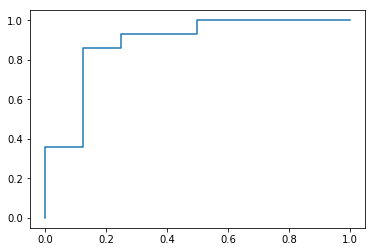

AUC:  0.8839285714285714
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.8181818181818182
Predicted Result  0   1
Actual Result          
0                 6   2
1                 2  12
XGBoost F1 Score: 0.494949494949495
Predicted Result   1
Actual Result       
0                  8
1                 14


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



In [1292]:
returned_model = run_full_model(37042, 'positive_6mo_change')

In [1084]:
returned_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### Iterate Over Predictions

In [1126]:
good_zips = [77449, 37013, 37042, 77479]

good_zips2 = [60629, 78704, 75287, 30024, 78745, 28027,
              48197, 66062, 95630, 90044, 90805]

good_zips3 = [92683, 37075, 87114, 6010, 78240, 87111, 76063, 33908, 97229, 91709, 92677]

good_zips4 = [77845, 45011, 29732, 28314, 87120, 40475, 23320]

good_zips5 = [21740, 34711, 19111, 74012, 27834, 21117, 92109, 48103, 30062, 75206, 2360]

In [1106]:
prediction_list = ['positive_3mo_change', 'positive_6mo_change', 'positive_12mo_change', 
                   'two_percent_plus_12mo', 'five_percent_plus_12mo'] 
# 'positive_3mo_change', 'positive_6mo_change', 'positive_12mo_change', ,'ten_percent_plus_12mo' removed for being imbalanced

# iterate over a list of types of predictions and show the results for each
def iterate_over_predictions(zip_code, prediction_list):
    for p in prediction_list:
        print(run_full_model(zip_code,p))

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.06890525 0.13398226 0.28662752 0.12230862 0.0763358  0.1063531
 0.20548745]


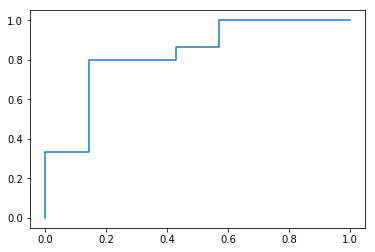

AUC:  0.8285714285714285
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.7365967365967365
Predicted Result  0   1
Actual Result          
0                 6   1
1                 5  10
XGBoost F1 Score: 0.7801544860368389
Predicted Result  0   1
Actual Result          
0                 6   1
1                 4  11
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=10, learning_rate=0.3, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.1522281  0.07859916 0.34194477 0.11878304 0.07743816 0.11816525
 0.11284153]


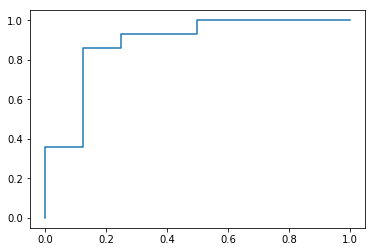

AUC:  0.8839285714285714
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.8181818181818182
Predicted Result  0   1
Actual Result          
0                 6   2
1                 2  12
XGBoost F1 Score: 0.494949494949495
Predicted Result   1
Actual Result       
0                  8
1                 14
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.22916267 0.1889636  0.11361163 0.08211502 0.18651752 0.16380747
 0.0358221 ]


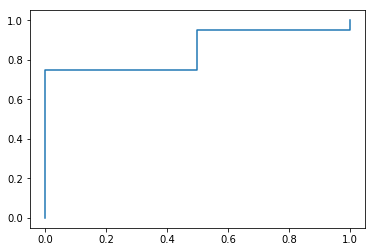

AUC:  0.85
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 0.8755244755244757
Predicted Result  0   1
Actual Result          
0                 1   1
1                 2  18
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.0885857  0.30319216 0.17086362 0.0090725  0.156837   0.14048673
 0.13096229]


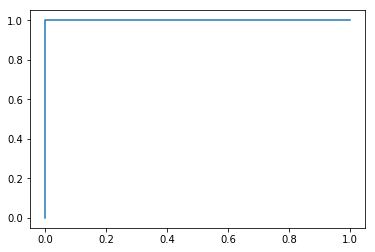

AUC:  1.0
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   0   1
Actual Result           
0                 11   0
1                  0  11
XGBoost F1 Score: 1.0
Predicted Result   0   1
Actual Result           
0                 11   0
1                  0  11
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.19648142 0.29209166 0.12433287 0.0436542  0.13032636 0.12208397
 0.09102953]


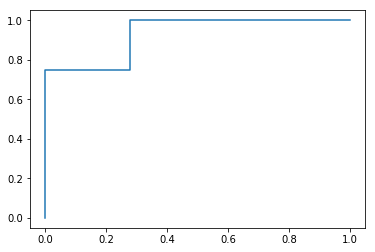

AUC:  0.9305555555555556
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.951912951912952
Predicted Result   0  1
Actual Result          
0                 18  0
1                  1  3
XGBoost F1 Score: 0.951912951912952
Predicted Result   0  1
Actual Result          
0                 18  0
1                  1  3
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.19473617 0.10639839 0.06196964 0.09988552 0.14479189 0.09828771
 0.2939307 ]


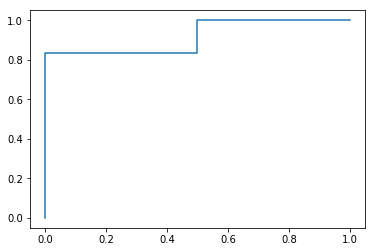

AUC:  0.9166666666666667
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18
XGBoost F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.23910521 0.15360077 0.09531932 0.06505488 0.11499501 0.11876717
 0.21315764]


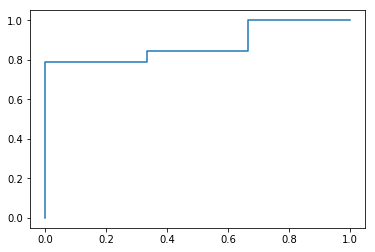

AUC:  0.8771929824561403
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.2342915  0.20846975 0.10325439 0.05665702 0.12138483 0.1460784
 0.12986411]


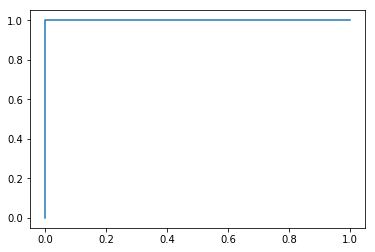

AUC:  1.0
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result  0   1
Actual Result          
0                 1   0
1                 0  21
XGBoost F1 Score: 0.9323467230443975
Predicted Result   1
Actual Result       
0                  1
1                 21
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.2956263  0.02187858 0.06824495 0.02878169 0.1405002  0.16199735
 0.28297093]


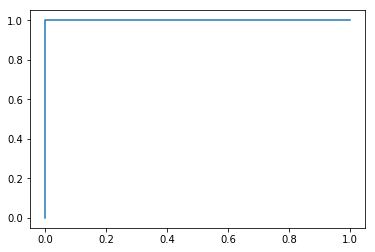

AUC:  1.0
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result  0   1
Actual Result          
0                 8   0
1                 0  14
XGBoost F1 Score: 0.9550406020994257
Predicted Result  0   1
Actual Result          
0                 8   0
1                 1  13
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.30830437 0.03071023 0.07268913 0.02972655 0.1111658  0.13147888
 0.31592505]


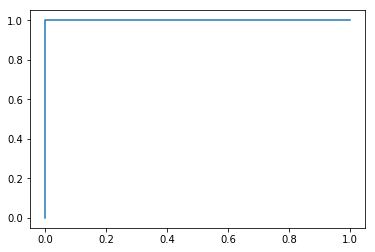

AUC:  1.0
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result  0   1
Actual Result          
0                 9   0
1                 0  13
XGBoost F1 Score: 1.0
Predicted Result  0   1
Actual Result          
0                 9   0
1                 0  13
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.27420668 0.16651658 0.09711494 0.13830056 0.08131912 0.0660123
 0.17652981]


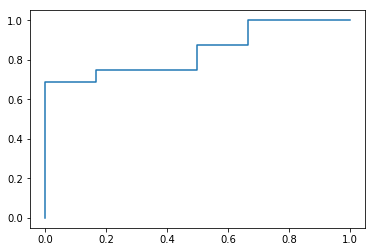

AUC:  0.84375
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.7828282828282828
Predicted Result  0   1
Actual Result          
0                 2   4
1                 0  16
XGBoost F1 Score: 0.6124401913875599
Predicted Result   1
Actual Result       
0                  6
1                 16
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.146161   0.15914269 0.09976292 0.15642362 0.08891211 0.05641688
 0.27318077]


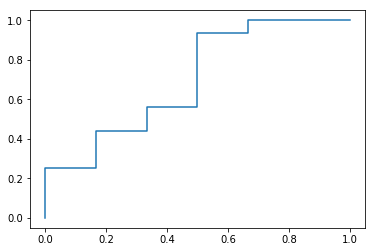

AUC:  0.6979166666666667
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.6124401913875599
Predicted Result   1
Actual Result       
0                  6
1                 16
XGBoost F1 Score: 0.6124401913875599
Predicted Result   1
Actual Result       
0                  6
1                 16
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[0.09495117 0.13298577 0.08571354 0.14066414 0.04137997 0.01781461
 0.1464908 ]


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



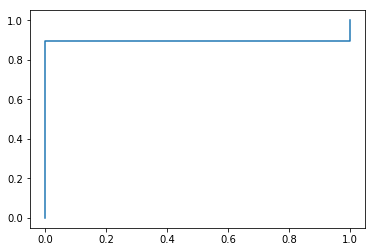

AUC:  0.8947368421052632
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.13476954 0.19998964 0.13150707 0.10908808 0.09371784 0.17532945
 0.15559837]


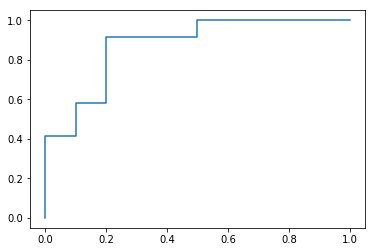

AUC:  0.875
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 0.47933884297520657
Predicted Result  0   1
Actual Result          
0                 1   9
1                 0  12
XGBoost F1 Score: 0.38502673796791437
Predicted Result   1
Actual Result       
0                 10
1                 12
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.31241255 0.35548337 0.05449492 0.09073347 0.01227654 0.04034338
 0.13425576]


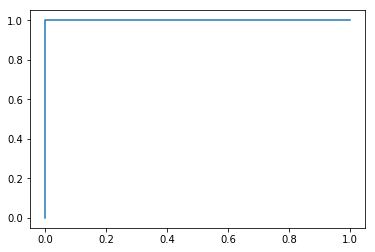

AUC:  1.0
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.955276907001045
Predicted Result   0  1
Actual Result          
0                 14  1
1                  0  7
XGBoost F1 Score: 0.955276907001045
Predicted Result   0  1
Actual Result          
0                 14  1
1                  0  7
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.15676484 0.24014504 0.09877289 0.09394446 0.19744715 0.118176
 0.09474961]


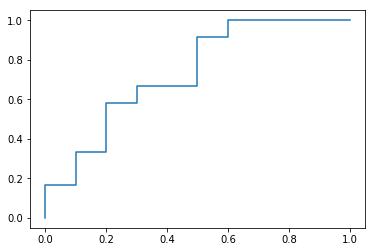

AUC:  0.7333333333333333
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.6562173458725181
Predicted Result  0   1
Actual Result          
0                 4   6
1                 1  11
XGBoost F1 Score: 0.38502673796791437
Predicted Result   1
Actual Result       
0                 10
1                 12
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.21527321 0.07406169 0.08443828 0.07729535 0.2558338  0.18263578
 0.11046189]


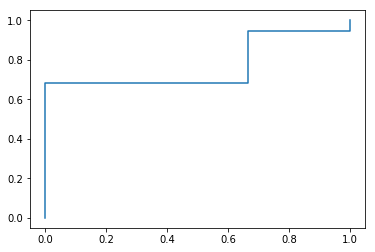

AUC:  0.7719298245614035
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.7858897858897861
Predicted Result  0   1
Actual Result          
0                 1   2
1                 3  16
XGBoost F1 Score: 0.6877005347593584
Predicted Result  0   1
Actual Result          
0                 1   2
1                 6  13
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.08821896 0.21737659 0.10638776 0.04171854 0.22202426 0.16974811
 0.15452578]


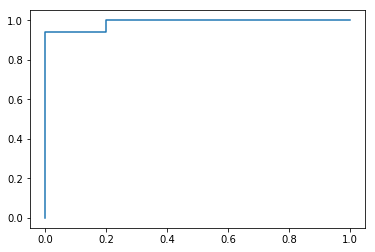

AUC:  0.9882352941176471
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 0.8399438399438399
Predicted Result  0   1
Actual Result          
0                 2   3
1                 0  17
XGBoost F1 Score: 0.6736596736596737
Predicted Result   1
Actual Result       
0                  5
1                 17
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[0.09969953 0.22224036 0.07288211 0.12204496 0.12259417 0.07999564
 0.28054323]


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



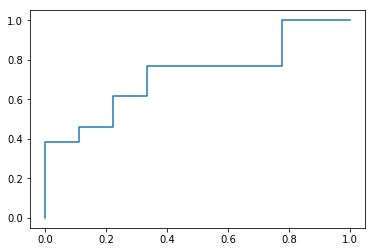

AUC:  0.7264957264957266
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 0.6393939393939394
Predicted Result  0  1
Actual Result         
0                 6  3
1                 5  8
XGBoost F1 Score: 0.23753665689149564
Predicted Result   0
Actual Result       
0                  9
1                 13
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.22094598 0.06213797 0.08223018 0.12446069 0.05810188 0.05826875
 0.39385456]


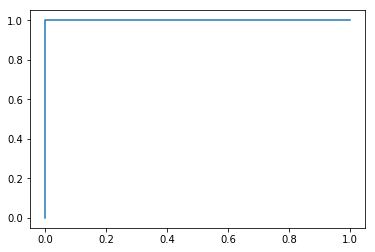

AUC:  1.0
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.827972027972028
Predicted Result   0  1
Actual Result          
0                 18  0
1                  3  1
XGBoost F1 Score: 0.7363636363636363
Predicted Result   0
Actual Result       
0                 18
1                  4
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.27513045 0.06838564 0.13627687 0.08115037 0.07956228 0.13757644
 0.22191795]


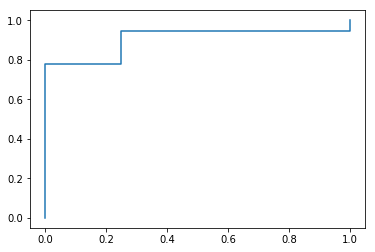

AUC:  0.9027777777777777
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18
XGBoost F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.21529359 0.06351834 0.17282917 0.10470581 0.10219697 0.06102137
 0.28043474]


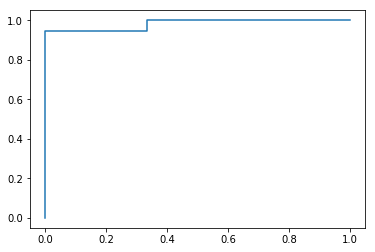

AUC:  0.9824561403508772
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



KeyboardInterrupt: 

In [1293]:
for m in modeled_zipcodes:
    iterate_over_predictions(m, prediction_list)

In [1009]:
# iterate over a list of types of predictions and get the best model for each prediction, save to a [dictionary]?

def gather_models_zip(zip_code, prediction_list):
    models_dict = {}
    for p in prediction_list:
        models_dict[p] = run_full_model(zip_code,p)
    return models_dict

In [1010]:
gather_models_zip(77494, prediction_list)

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.31806897 0.0549442  0.14948799 0.03701764 0.07307767 0.15223911
 0.21516443]
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.9526695526695526
Predicted Result  0   1
Actual Result          
0                 4   1
1                 0  17
XGBoost F1 Score: 0.6736596736596737
Predicted Result   1
Actual Result       
0                  5
1                 17


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.35351473 0.07952628 0.05824746 0.09667748 0.10822902 0.07365014
 0.23015489]
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 1.0
Predicted Result  0   1
Actual Result          
0                 4   0
1                 0  18
XGBoost F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.33582065 0.07782843 0.03485946 0.16836697 0.09124368 0.05235119
 0.23952962]
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 0.8715338715338716
Predicted Result  0   1
Actual Result          
0                 2   1
1                 2  17
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.29773204 0.11190981 0.06350553 0.11983203 0.08527267 0.04012233
 0.28162559]
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 0.8053475935828878
Predicted Result  0   1
Actual Result          
0                 3   3
1                 1  15
XGBoost F1 Score: 0.6124401913875599
Predicted Result   1
Actual Result       
0                  6
1                 16


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.31954668 0.12658443 0.11807664 0.04878831 0.06808655 0.03051754
 0.28839986]
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.9546395633352156
Predicted Result   0   1
Actual Result           
0                 10   0
1                  1  11
XGBoost F1 Score: 0.8627893845285151
Predicted Result   0  1
Actual Result          
0                 10  0
1                  3  9


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.02855022 0.12096558 0.20021013 0.03997154 0.0717228  0.02489801
 0.12368172]
---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.7363636363636363
Predicted Result   0
Actual Result       
0                 18
1                  4
XGBoost F1 Score: 0.7363636363636363
Predicted Result   0
Actual Result       
0                 18
1                  4


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



{'positive_3mo_change': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
 'positive_6mo_change': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
 'positive_12mo_change': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2,

In [1014]:
# iterate over a list of zip codes and get the models for each prediction in prediction list
# combine the models dictionary for each zip code into a master dictionary

def gather_models_list_of_zips(list_of_zips, prediction_list):
    master_dict = {}
    for l in list_of_zips:
        data = gather_models_zip(l,prediction_list)
        master_dict[l] = data
    
    return master_dict

[0.06890525 0.13398226 0.28662752 0.12230862 0.0763358  0.1063531
 0.20548745]


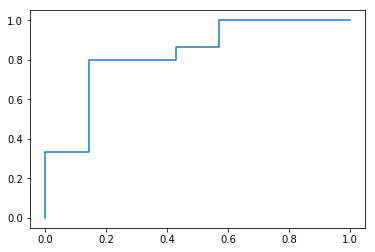

AUC:  0.8285714285714285
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.7365967365967365
Predicted Result  0   1
Actual Result          
0                 6   1
1                 5  10
XGBoost F1 Score: 0.7801544860368389
Predicted Result  0   1
Actual Result          
0                 6   1
1                 4  11


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.1522281  0.07859916 0.34194477 0.11878304 0.07743816 0.11816525
 0.11284153]


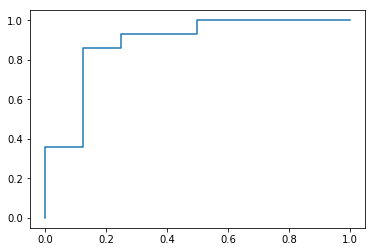

AUC:  0.8839285714285714
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.8181818181818182
Predicted Result  0   1
Actual Result          
0                 6   2
1                 2  12
XGBoost F1 Score: 0.494949494949495
Predicted Result   1
Actual Result       
0                  8
1                 14


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.22916267 0.1889636  0.11361163 0.08211502 0.18651752 0.16380747
 0.0358221 ]


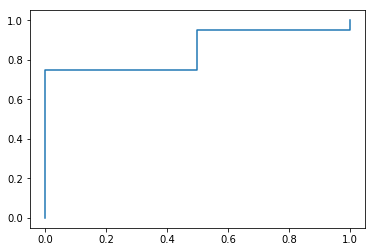

AUC:  0.85
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 0.8755244755244757
Predicted Result  0   1
Actual Result          
0                 1   1
1                 2  18
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.0885857  0.30319216 0.17086362 0.0090725  0.156837   0.14048673
 0.13096229]


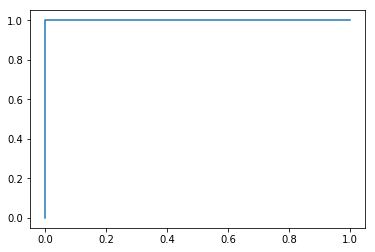

AUC:  1.0
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   0   1
Actual Result           
0                 11   0
1                  0  11
XGBoost F1 Score: 1.0
Predicted Result   0   1
Actual Result           
0                 11   0
1                  0  11


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.19648142 0.29209166 0.12433287 0.0436542  0.13032636 0.12208397
 0.09102953]


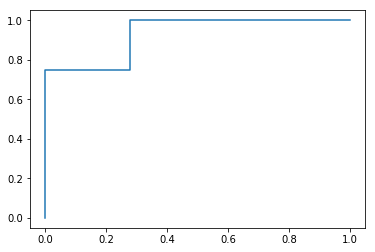

AUC:  0.9305555555555556
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.951912951912952
Predicted Result   0  1
Actual Result          
0                 18  0
1                  1  3
XGBoost F1 Score: 0.951912951912952
Predicted Result   0  1
Actual Result          
0                 18  0
1                  1  3


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.19473617 0.10639839 0.06196964 0.09988552 0.14479189 0.09828771
 0.2939307 ]


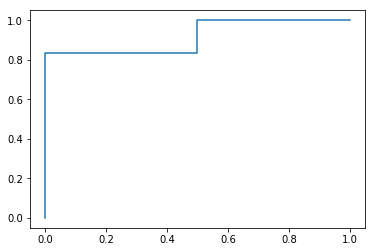

AUC:  0.9166666666666667
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18
XGBoost F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.23910521 0.15360077 0.09531932 0.06505488 0.11499501 0.11876717
 0.21315764]


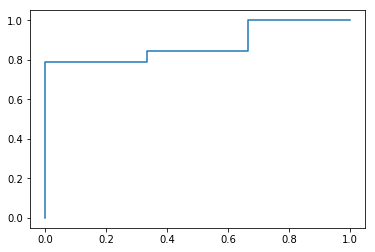

AUC:  0.8771929824561403
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.2342915  0.20846975 0.10325439 0.05665702 0.12138483 0.1460784
 0.12986411]


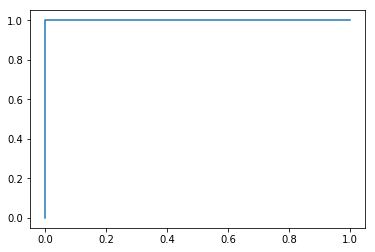

AUC:  1.0
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result  0   1
Actual Result          
0                 1   0
1                 0  21
XGBoost F1 Score: 0.9323467230443975
Predicted Result   1
Actual Result       
0                  1
1                 21


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[0.2956263  0.02187858 0.06824495 0.02878169 0.1405002  0.16199735
 0.28297093]


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



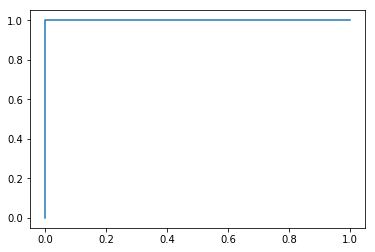

AUC:  1.0
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result  0   1
Actual Result          
0                 8   0
1                 0  14
XGBoost F1 Score: 0.9550406020994257
Predicted Result  0   1
Actual Result          
0                 8   0
1                 1  13


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.30830437 0.03071023 0.07268913 0.02972655 0.1111658  0.13147888
 0.31592505]


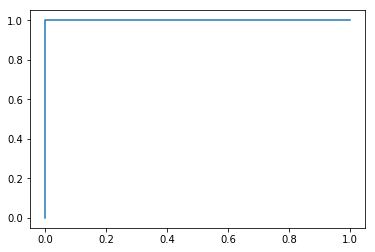

AUC:  1.0
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result  0   1
Actual Result          
0                 9   0
1                 0  13
XGBoost F1 Score: 1.0
Predicted Result  0   1
Actual Result          
0                 9   0
1                 0  13


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.27420668 0.16651658 0.09711494 0.13830056 0.08131912 0.0660123
 0.17652981]


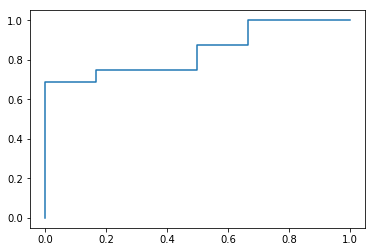

AUC:  0.84375
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.7828282828282828
Predicted Result  0   1
Actual Result          
0                 2   4
1                 0  16
XGBoost F1 Score: 0.6124401913875599
Predicted Result   1
Actual Result       
0                  6
1                 16


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.146161   0.15914269 0.09976292 0.15642362 0.08891211 0.05641688
 0.27318077]


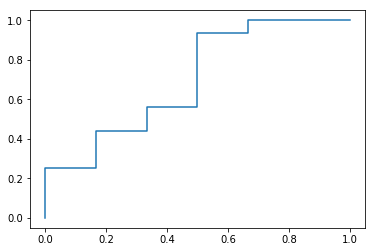

AUC:  0.6979166666666667
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.6124401913875599
Predicted Result   1
Actual Result       
0                  6
1                 16
XGBoost F1 Score: 0.6124401913875599
Predicted Result   1
Actual Result       
0                  6
1                 16


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.09495117 0.13298577 0.08571354 0.14066414 0.04137997 0.01781461
 0.1464908 ]


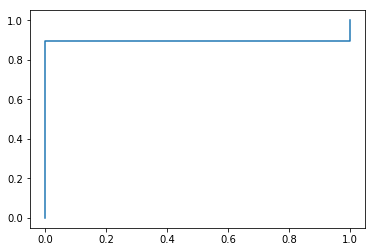

AUC:  0.8947368421052632
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[0.13476954 0.19998964 0.13150707 0.10908808 0.09371784 0.17532945
 0.15559837]


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



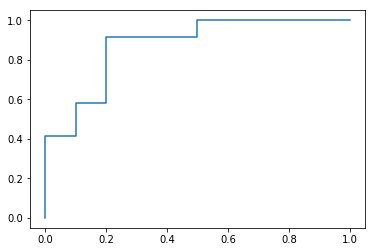

AUC:  0.875
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 0.47933884297520657
Predicted Result  0   1
Actual Result          
0                 1   9
1                 0  12
XGBoost F1 Score: 0.38502673796791437
Predicted Result   1
Actual Result       
0                 10
1                 12


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



[0.31241255 0.35548337 0.05449492 0.09073347 0.01227654 0.04034338
 0.13425576]


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



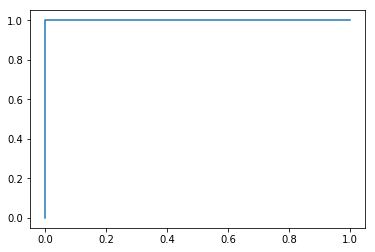

AUC:  1.0
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.955276907001045
Predicted Result   0  1
Actual Result          
0                 14  1
1                  0  7
XGBoost F1 Score: 0.955276907001045
Predicted Result   0  1
Actual Result          
0                 14  1
1                  0  7


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.15676484 0.24014504 0.09877289 0.09394446 0.19744715 0.118176
 0.09474961]


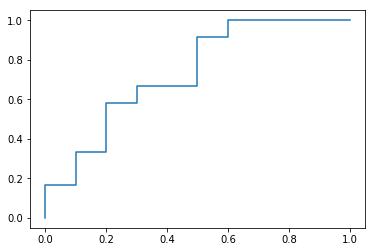

AUC:  0.7333333333333333
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.6562173458725181
Predicted Result  0   1
Actual Result          
0                 4   6
1                 1  11
XGBoost F1 Score: 0.38502673796791437
Predicted Result   1
Actual Result       
0                 10
1                 12


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.21527321 0.07406169 0.08443828 0.07729535 0.2558338  0.18263578
 0.11046189]


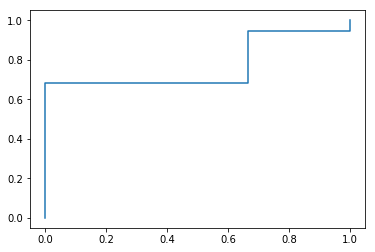

AUC:  0.7719298245614035
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.7858897858897861
Predicted Result  0   1
Actual Result          
0                 1   2
1                 3  16
XGBoost F1 Score: 0.6877005347593584
Predicted Result  0   1
Actual Result          
0                 1   2
1                 6  13


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.08821896 0.21737659 0.10638776 0.04171854 0.22202426 0.16974811
 0.15452578]


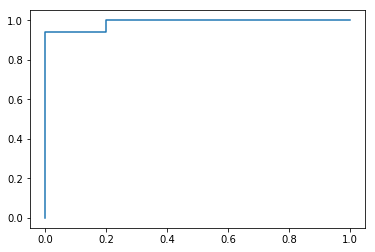

AUC:  0.9882352941176471
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 0.8399438399438399
Predicted Result  0   1
Actual Result          
0                 2   3
1                 0  17
XGBoost F1 Score: 0.6736596736596737
Predicted Result   1
Actual Result       
0                  5
1                 17


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.09969953 0.22224036 0.07288211 0.12204496 0.12259417 0.07999564
 0.28054323]


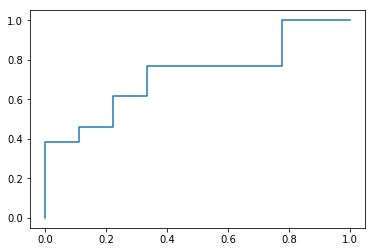

AUC:  0.7264957264957266
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 0.6393939393939394
Predicted Result  0  1
Actual Result         
0                 6  3
1                 5  8
XGBoost F1 Score: 0.23753665689149564
Predicted Result   0
Actual Result       
0                  9
1                 13


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.22094598 0.06213797 0.08223018 0.12446069 0.05810188 0.05826875
 0.39385456]


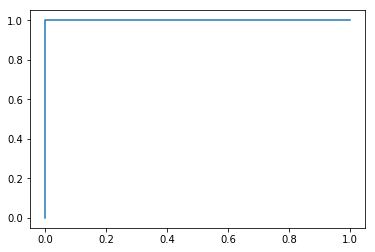

AUC:  1.0
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.827972027972028
Predicted Result   0  1
Actual Result          
0                 18  0
1                  3  1
XGBoost F1 Score: 0.7363636363636363
Predicted Result   0
Actual Result       
0                 18
1                  4


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.27513045 0.06838564 0.13627687 0.08115037 0.07956228 0.13757644
 0.22191795]


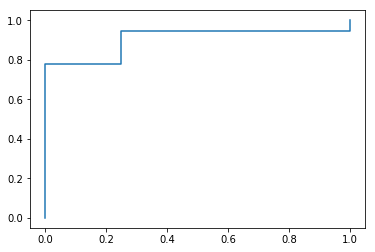

AUC:  0.9027777777777777
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18
XGBoost F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.21529359 0.06351834 0.17282917 0.10470581 0.10219697 0.06102137
 0.28043474]


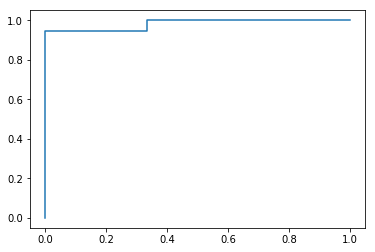

AUC:  0.9824561403508772
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.20479081 0.07673935 0.14500501 0.10882096 0.09148696 0.05073322
 0.3224237 ]


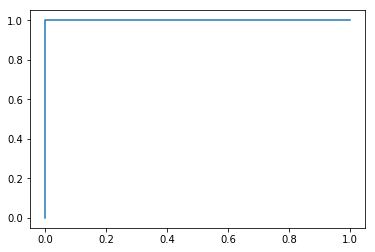

AUC:  1.0
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result  0   1
Actual Result          
0                 1   0
1                 0  21
XGBoost F1 Score: 0.9323467230443975
Predicted Result   1
Actual Result       
0                  1
1                 21


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.05153762 0.10235125 0.26829303 0.13997427 0.07673067 0.149268
 0.21184516]


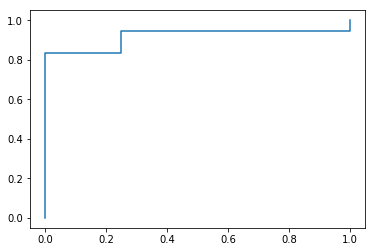

AUC:  0.9166666666666666
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 0.9090909090909091
Predicted Result  0   1
Actual Result          
0                 3   1
1                 1  17
XGBoost F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.11625009 0.11387306 0.15763811 0.12671105 0.05159254 0.08175802
 0.35217712]


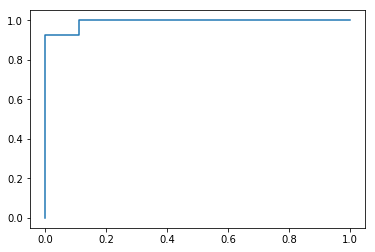

AUC:  0.9914529914529915
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.9098484848484848
Predicted Result  0   1
Actual Result          
0                 9   0
1                 2  11
XGBoost F1 Score: 0.8181818181818182
Predicted Result  0  1
Actual Result         
0                 9  0
1                 4  9


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.1310376  0.14524945 0.05943777 0.20375395 0.14247723 0.07759753
 0.15044646]


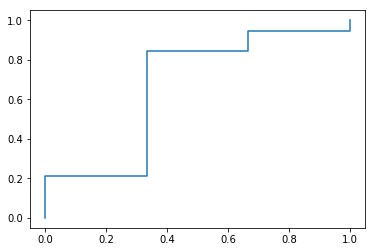

AUC:  0.6666666666666667
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.07061714 0.16098671 0.06892863 0.16837055 0.11241212 0.09065414
 0.18803071]


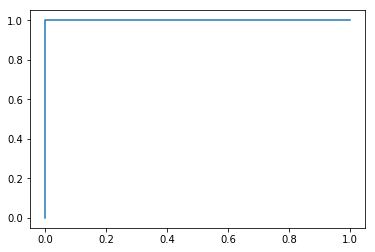

AUC:  1.0
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.06332279 0.13895315 0.09844359 0.09843419 0.1475375  0.03121332
 0.10209547]


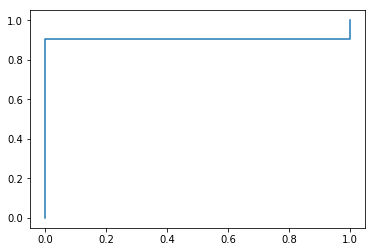

AUC:  0.9047619047619048
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 0.9323467230443975
Predicted Result   1
Actual Result       
0                  1
1                 21
XGBoost F1 Score: 0.9323467230443975
Predicted Result   1
Actual Result       
0                  1
1                 21


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.08803483 0.38669867 0.12781116 0.10241267 0.08265221 0.0635393
 0.14885116]


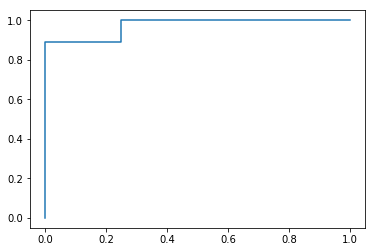

AUC:  0.9722222222222222
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 0.8963317384370018
Predicted Result  0   1
Actual Result          
0                 2   2
1                 0  18
XGBoost F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.07218719 0.46643964 0.0408971  0.08237115 0.06858284 0.01989171
 0.24963036]


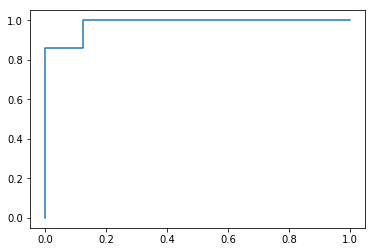

AUC:  0.9821428571428571
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.9538140020898641
Predicted Result  0   1
Actual Result          
0                 7   1
1                 0  14
XGBoost F1 Score: 0.9550406020994257
Predicted Result  0   1
Actual Result          
0                 8   0
1                 1  13


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.20683204 0.18758757 0.05218657 0.09015111 0.12004393 0.05466387
 0.27853492]


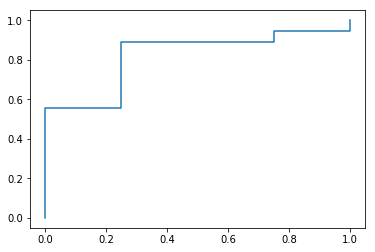

AUC:  0.8194444444444444
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18
XGBoost F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.14217267 0.23082971 0.04160481 0.09345916 0.12879851 0.16461519
 0.18851994]


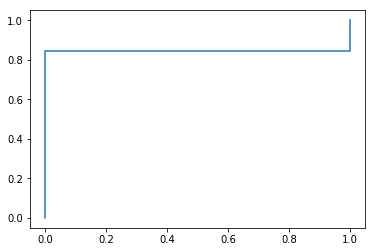

AUC:  0.8421052631578947
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.11931273 0.13390216 0.26210997 0.08754385 0.12413491 0.1201541
 0.06284229]


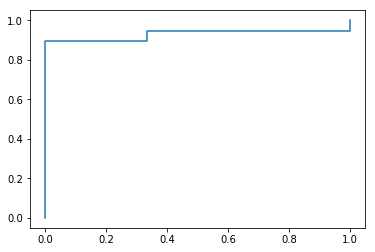

AUC:  0.9298245614035088
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.18256831 0.16568422 0.04397163 0.15545113 0.17818707 0.15840338
 0.10573426]


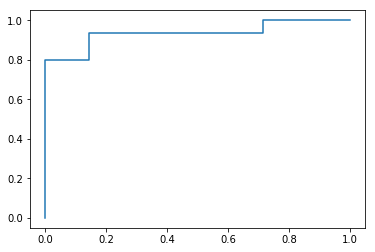

AUC:  0.9333333333333333
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 0.6887700534759358
Predicted Result  0   1
Actual Result          
0                 2   5
1                 1  14
XGBoost F1 Score: 0.5528255528255529
Predicted Result   1
Actual Result       
0                  7
1                 15


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.19299956 0.24904863 0.05705846 0.15638105 0.15605788 0.14579852
 0.0426559 ]


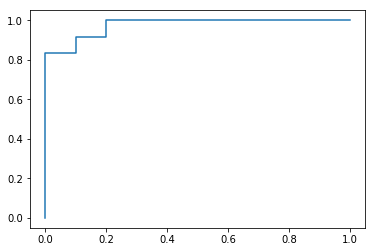

AUC:  0.9750000000000001
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.8627751196172249
Predicted Result  0   1
Actual Result          
0                 8   2
1                 1  11
XGBoost F1 Score: 0.5606060606060606
Predicted Result  0   1
Actual Result          
0                 2   8
1                 0  12


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.08243951 0.27454015 0.07647702 0.12828745 0.14258694 0.10926657
 0.18640236]


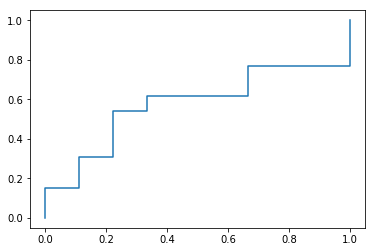

AUC:  0.5726495726495726
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.4171122994652407
Predicted Result  0   1
Actual Result          
0                 0   9
1                 1  12
XGBoost F1 Score: 0.438961038961039
Predicted Result   1
Actual Result       
0                  9
1                 13


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.12916325 0.18218296 0.15372901 0.20511143 0.16647601 0.12163651
 0.04170083]


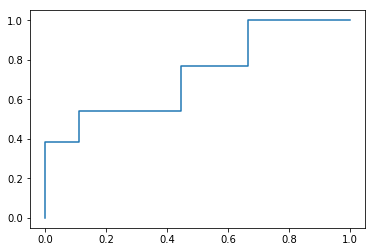

AUC:  0.7264957264957266
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.6846590909090909
Predicted Result  0   1
Actual Result          
0                 3   6
1                 0  13
XGBoost F1 Score: 0.438961038961039
Predicted Result   1
Actual Result       
0                  9
1                 13


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.11115343 0.13606971 0.10262609 0.2381674  0.21314522 0.16089677
 0.03794139]


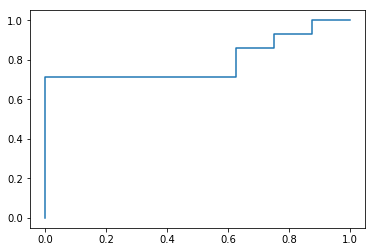

AUC:  0.7946428571428572
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 0.6225108225108226
Predicted Result  0   1
Actual Result          
0                 3   5
1                 3  11
XGBoost F1 Score: 0.494949494949495
Predicted Result   1
Actual Result       
0                  8
1                 14


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.07076447 0.21857199 0.05695563 0.18148976 0.19219231 0.15484879
 0.12517706]


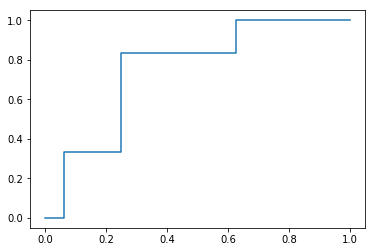

AUC:  0.75
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 0.6721763085399449
Predicted Result   0  1
Actual Result          
0                 13  3
1                  4  2
XGBoost F1 Score: 0.6124401913875599
Predicted Result   0
Actual Result       
0                 16
1                  6


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.08986336 0.04547629 0.18679179 0.10527314 0.0736098  0.04373741
 0.05524821]


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



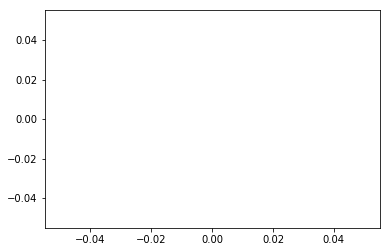

AUC:  nan
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   0
Actual Result       
0                 22
XGBoost F1 Score: 1.0
Predicted Result   0
Actual Result       
0                 22


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.06152005 0.13476841 0.11221484 0.12114332 0.28058283 0.25894628
 0.03082427]


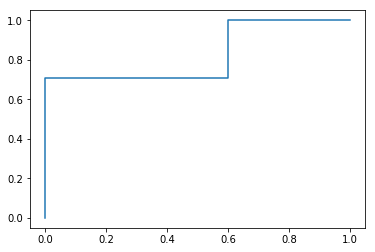

AUC:  0.8235294117647058
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.7272727272727273
Predicted Result  0   1
Actual Result          
0                 2   3
1                 3  14
XGBoost F1 Score: 0.6736596736596737
Predicted Result   1
Actual Result       
0                  5
1                 17


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.08313006 0.10199958 0.1217085  0.10894127 0.31213881 0.21971065
 0.05237115]


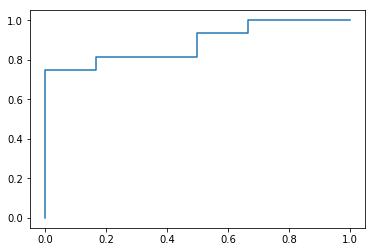

AUC:  0.8854166666666667
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.8053475935828878
Predicted Result  0   1
Actual Result          
0                 3   3
1                 1  15
XGBoost F1 Score: 0.6124401913875599
Predicted Result   1
Actual Result       
0                  6
1                 16


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.08906324 0.19133372 0.04551384 0.1022439  0.09433056 0.06655366
 0.06096108]


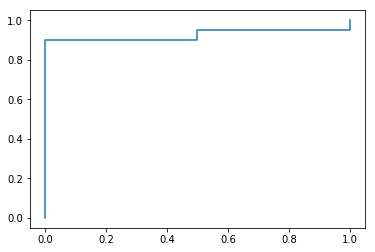

AUC:  0.925
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.05904671 0.18375561 0.03834119 0.0992474  0.32288364 0.26404765
 0.03267779]


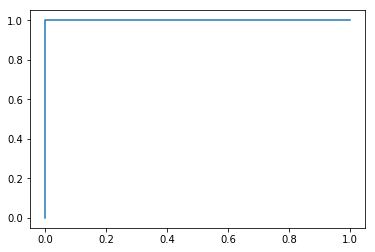

AUC:  1.0
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 0.9542583732057417
Predicted Result  0   1
Actual Result          
0                 9   1
1                 0  12
XGBoost F1 Score: 0.38502673796791437
Predicted Result   1
Actual Result       
0                 10
1                 12


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.07846334 0.143334   0.0403531  0.14360471 0.27610105 0.201116
 0.11702781]


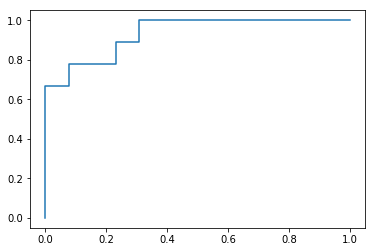

AUC:  0.9316239316239316
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.8621509209744506
Predicted Result   0  1
Actual Result          
0                 12  1
1                  2  7
XGBoost F1 Score: 0.8181818181818182
Predicted Result   0  1
Actual Result          
0                 11  2
1                  2  7


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.24550867 0.11487954 0.09546178 0.13332217 0.16788727 0.15999293
 0.08294764]


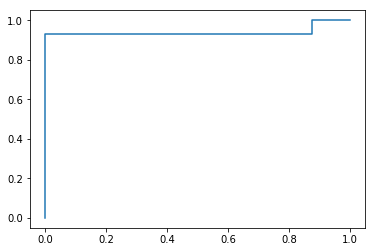

AUC:  0.9375
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.6988636363636365
Predicted Result  0   1
Actual Result          
0                 3   5
1                 1  13
XGBoost F1 Score: 0.494949494949495
Predicted Result   1
Actual Result       
0                  8
1                 14


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.23358446 0.19459528 0.04000381 0.11882205 0.13347655 0.18812774
 0.09139011]


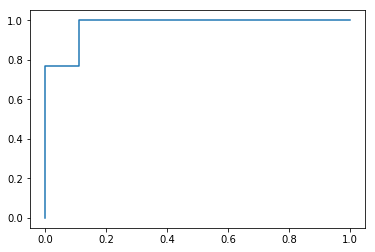

AUC:  0.9743589743589743
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.6846590909090909
Predicted Result  0   1
Actual Result          
0                 3   6
1                 0  13
XGBoost F1 Score: 0.438961038961039
Predicted Result   1
Actual Result       
0                  9
1                 13


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.21832543 0.1828667  0.04951243 0.09712239 0.19977692 0.14746684
 0.10492928]


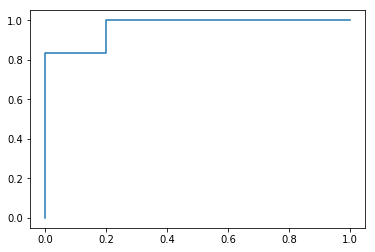

AUC:  0.9666666666666668
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 0.754440961337513
Predicted Result  0   1
Actual Result          
0                 5   5
1                 0  12
XGBoost F1 Score: 0.38502673796791437
Predicted Result   1
Actual Result       
0                 10
1                 12


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.20445128 0.17604298 0.03803851 0.08340199 0.20172324 0.19694716
 0.09939485]


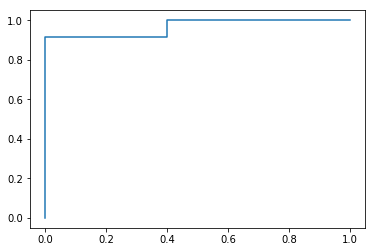

AUC:  0.9666666666666667
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 0.8084415584415584
Predicted Result  0   1
Actual Result          
0                 6   4
1                 0  12
XGBoost F1 Score: 0.38502673796791437
Predicted Result   1
Actual Result       
0                 10
1                 12


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.27842521 0.17767957 0.02364304 0.06813198 0.14224818 0.1508245
 0.15904751]


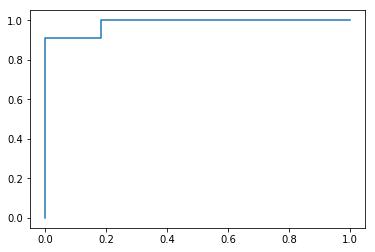

AUC:  0.9834710743801652
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.9544513457556936
Predicted Result   0   1
Actual Result           
0                 11   0
1                  1  10
XGBoost F1 Score: 0.8610526315789474
Predicted Result  0   1
Actual Result          
0                 8   3
1                 0  11


In [1294]:
#good_zips = [77449, 37013, 37042, 77479]

output = gather_models_list_of_zips(modeled_zipcodes, prediction_list)

In [1295]:
pickle_out = open("modeled_zipcodes_dict.pickle","wb")
pickle.dump(output, pickle_out)
pickle_out.close()

### Get Feature Importances

In [1299]:
predictions = ['positive_3mo_change','positive_6mo_change','positive_12mo_change',
              'two_percent_plus_12mo', 'five_percent_plus_12mo']

In [1298]:
output

{37042: {'positive_3mo_change': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=0.4, gamma=10, learning_rate=0.3, max_delta_step=0,
         max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
         n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
         reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
         silent=True, subsample=0.8),
  'positive_6mo_change': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=2, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
              oob_score=False, random_state=0, verbose=0, warm_start=False),
  'positive_12mo_change': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max

In [1315]:
feature_importance_dict = {}

for p in predictions:
    for o in output.keys():
        if p in feature_importance_dict.keys():
            feature_importance_dict[p].append(output[o][p].feature_importances_)
        else:
            feature_importance_dict[p] = [output[o][p].feature_importances_]
        #print(output[o][p].feature_importances_)
        
pd.DataFrame(feature_importance_dict['positive_12mo_change'])

,0,1,2,3,4,5,6
0,0.229163,0.188964,0.113612,0.082115,0.186518,0.163807,0.035822
1,0.234292,0.208470,0.103254,0.056657,0.121385,0.146078,0.129864
2,0.094951,0.132986,0.085714,0.140664,0.041380,0.017815,0.146491
3,0.088219,0.217377,0.106388,0.041719,0.222024,0.169748,0.154526
4,0.204791,0.076739,0.145005,0.108821,0.091487,0.050733,0.322424
5,0.063323,0.138953,0.098444,0.098434,0.147538,0.031213,0.102095
6,0.119313,0.133902,0.262110,0.087544,0.124135,0.120154,0.062842
7,0.111153,0.136070,0.102626,0.238167,0.213145,0.160897,0.037941
8,0.089063,0.191334,0.045514,0.102244,0.094331,0.066554,0.060961
9,0.218325,0.182867,0.049512,0.097122,0.199777,0.147467,0.104929


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.31806897 0.0549442  0.14948799 0.03701764 0.07307767 0.15223911
 0.21516443]
---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.9526695526695526
Predicted Result  0   1
Actual Result          
0                 4   1
1                 0  17
XGBoost F1 Score: 0.6736596736596737
Predicted Result   1
Actual Result       
0                  5
1                 17
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.35351473 0.07952628 0.05824746 0.09667748 0.10822902 0.07365014
 0.23015489]
---------
Predicting positive_6mo_change...
Random Forest F1 Score: 1.0
Predicted Result  0   1
Actual Result          
0                 4   0
1                 0  18
XGBoost F1 Score: 0.7363636363636363
Predicted Result   1
Actual Result       
0                  4
1                 18
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.33582065 0.07782843 0.03485946 0.16836697 0.09124368 0.05235119
 0.23952962]
---------
Predicting positive_12mo_change...
Random Forest F1 Score: 0.8715338715338716
Predicted Result  0   1
Actual Result          
0                 2   1
1                 2  17
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.29773204 0.11190981 0.06350553 0.11983203 0.08527267 0.04012233
 0.28162559]
---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 0.8053475935828878
Predicted Result  0   1
Actual Result          
0                 3   3
1                 1  15
XGBoost F1 Score: 0.6124401913875599
Predicted Result   1
Actual Result       
0                  6
1                 16
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.31954668 0.12658443 0.11807664 0.04878831 0.06808655 0.03051754
 0.28839986]
---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.9546395633352156
Predicted Result   0   1
Actual Result           
0                 10   0
1                  1  11
XGBoost F1 Score: 0.8627893845285151
Predicted Result   0  1
Actual Result          
0                 10  0
1                  3  9
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.02855022 0.12096558 0.20021013 0.03997154 0.0717228  0.02489801
 0.12368172]
---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.7363636363636363
Predicted Result   0
Actual Result       
0                 18
1                  4
XGBoost F1 Score: 0.7363636363636363
Predicted Result   0
Actual Result       
0                 18
1                  4
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



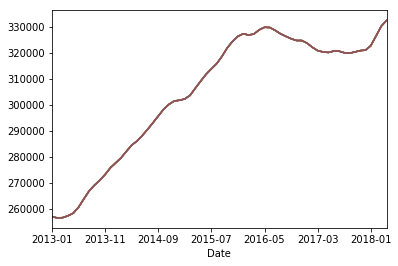

In [1004]:
iterate_over_predictions(77494, prediction_list)

In [923]:
# write a function that finds the area codes that have data that works

def check_zip(zip_code, start_date, end_date):
    data = join_data_available(zip_code, data_sets_dict)
    data = data[data['Date']>=start_date] 
    data = data[data['Date']<=end_date]
    
    for c in data.columns:
        if data[c].isnull().sum() > 0:
            return False
    
    features = ['foreclose_resales',
     'median_listing_price',
     'percent_listing_price_reductions',
     'median_percent_price_reductions',
     'monthly_listings_allhomes',
     'median_daily_listings',
     'price_to_rent_ratio']
    
    for f in features:
        if f not in data.columns:
            return False
    
    return True

In [926]:
check_zip(10467,'2013-12','2019-01')

False

In [927]:
def check_list_of_zips(list_of_zips, start_date, end_date):
    i = 0
    good_zips = []
    for l in list_of_zips:
        if check_zip(l,start_date,end_date):
            good_zips.append(l)
        print(i)
        i+=1
    return good_zips

In [1125]:
check_list_of_zips(list(zhvi_data['RegionName'][200:250]), '2013-12','2019-01')

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


[21740, 34711, 19111, 74012, 27834, 21117, 92109, 48103, 30062, 75206, 2360]

In [1033]:
good_zips = [77449, 37013, 37042, 77479, 30044]

good_zips2 = [60629, 78704, 75287, 30024, 78745, 28027,
              48197, 66062, 95630, 90044, 90805]

good_zips3 = [92683, 37075, 87114, 6010, 78240, 87111, 76063, 33908, 97229, 91709, 92677]

good_zips4 = [77845, 45011, 29732, 28314, 87120, 40475, 23320]

good_zips5plus = 

Predicting for: 60629...


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.9475240206947523
Predicted Result  0   1
Actual Result          
0                 1   1
1                 0  20
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.9026737967914439
Predicted Result  0   1
Actual Result          
0                 4   2
1                 0  16
XGBoost F1 Score: 0.6124401913875599
Predicted Result   1
Actual Result       
0                  6
1                 16
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.7363636363636363
Predicted Result   0
Actual Result       
0                 18
1                  4
XGBoost F1 Score: 0.7363636363636363
Predicted Result   0
Actual Result       
0                 18
1                  4
None
Predicting for: 78704...


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



---------
Predicting positive_3mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_6mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.8886363636363637
Predicted Result  0   1
Actual Result          
0                 1   2
1                 0  19
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.9090909090909091
Predicted Result   0  1
Actual Result          
0                 20  1
1                  1  0
XGBoost F1 Score: 0.9323467230443975
Predicted Result   0
Actual Result       
0                 21
1                  1
None
Predicting for: 75287...


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.9323467230443975
Predicted Result   1
Actual Result       
0                  1
1                 21
XGBoost F1 Score: 0.9323467230443975
Predicted Result   1
Actual Result       
0                  1
1                 21
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



---------
Predicting positive_6mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.7069147069147068
Predicted Result  0   1
Actual Result          
0                 1   5
1                 0  16
XGBoost F1 Score: 0.6124401913875599
Predicted Result   1
Actual Result       
0                  6
1                 16
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.827972027972028
Predicted Result   0  1
Actual Result          
0                 18  0
1                  3  1
XGBoost F1 Score: 0.7363636363636363
Predicted Result   0
Actual Result       
0                 18
1                  4
None
Predicting for: 30024...


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_3mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_6mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.9090909090909091
Predicted Result   0  1
Actual Result          
0                 19  1
1                  1  1
XGBoost F1 Score: 0.8658008658008658
Predicted Result   0
Actual Result       
0                 20
1                  2
None
Predicting for: 78745...


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_3mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_6mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.9323467230443975
Predicted Result   1
Actual Result       
0                  1
1                 21
XGBoost F1 Score: 0.9323467230443975
Predicted Result   1
Actual Result       
0                  1
1                 21
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.9090909090909091
Predicted Result   0  1
Actual Result          
0                 13  1
1                  1  7
XGBoost F1 Score: 0.8614420062695924
Predicted Result   0  1
Actual Result          
0                 13  1
1                  2  6
None
Predicting for: 28027...


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_3mo_change...
Random Forest F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_6mo_change...
Random Forest F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 0.7772727272727273
Predicted Result  0   1
Actual Result          
0                 0   3
1                 1  18
XGBoost F1 Score: 0.8004434589800443
Predicted Result   1
Actual Result       
0                  3
1                 19
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.9542583732057417
Predicted Result  0   1
Actual Result          
0                 9   1
1                 0  12
XGBoost F1 Score: 0.859180035650624
Predicted Result  0   1
Actual Result          
0                 7   3
1                 0  12
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   0
Actual Result       
0                 22
XGBoost F1 Score: 1.0
Predicted Result   0
Actual Result       
0                 22
None
Predicting for: 48197...


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_3mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_6mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting positive_12mo_change...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting two_percent_plus_12mo...
Random Forest F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
XGBoost F1 Score: 1.0
Predicted Result   1
Actual Result       
1                 22
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting five_percent_plus_12mo...
Random Forest F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
XGBoost F1 Score: 0.8658008658008658
Predicted Result   1
Actual Result       
0                  2
1                 20
None


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



---------
Predicting ten_percent_plus_12mo...
Random Forest F1 Score: 0.7992424242424243
Predicted Result   0  1
Actual Result          
0                 14  0
1                  4  4
XGBoost F1 Score: 0.494949494949495
Predicted Result   0
Actual Result       
0                 14
1                  8
None
Predicting for: 66062...


/Users/philglazer/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/philglazer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

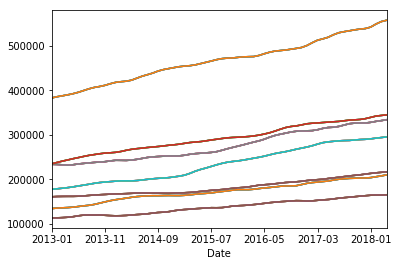

In [939]:
for g in good_zips2:
    print("Predicting for: " + str(g) + "...")
    iterate_over_predictions(g)